<a href="https://colab.research.google.com/github/wlr2678/ChangE_4_data_playground/blob/master/first_glance_own_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
pip install pds4_tools
pip install matplotlib
pip install numpy
pip install Pillow
pip install colour-science
pip install colour-demosaicing

In [ ]:
from pds4_tools import pds4_read       # to read and inspect the data and metadata
import matplotlib.pyplot as plt        # for plotting
import matplotlib
import numpy as np
from PIL import Image

import cv2 as cv # HDR tonemapping trial

import re # Regex for parsing header file

# for plotting in Jupyter notebooks
# %matplotlib notebook
# for plotting in Google Colab, inline with the cell outputs
# %matplotlib inline

from skimage import exposure
from skimage import data, img_as_float
import colour
from colour.plotting import *
import glob, os # for batch reading, processing and exporting in directories

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_Menon2007,
    mosaicing_CFA_Bayer)

cctf_encoding = colour.cctf_encoding
_ = colour.utilities.filter_warnings()
# colour.utilities.describe_environment();

def read_pds(path):
    data = pds4_read(path, quiet=True)
    img = np.array(data[0].data)
    img = img_as_float(img)
    return img

def debayer_img(img, CFArr='RGGB'):
    debayered = cctf_encoding(demosaicing_CFA_Bayer_bilinear(img, CFArr))
    return debayered

def stretch_img(img, percent=0.5):
    # cf https://www.harrisgeospatial.com/docs/BackgroundStretchTypes.html
    # Adapts for different percentages
    p2, p98 = np.percentile(img, (0+percent, 100-percent))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img

def check_type(p): # Check PCAM image type
    ty = p.split('_')[2].split('-')[1]
    return ty

def plot_img_and_hist(image, ty='Q', size=10,  hist=True, bins=128): # ty indicates the type of the data product
    """Plot an image along with its histogram.
    """
    if hist:
        fig, axes = plt.subplots(2,1, figsize=(size,size), gridspec_kw={'height_ratios': [3, 1]})
        ax_img, ax_hist = axes
    else:
        fig, ax_img = plt.subplots(figsize=(size,size))

    # Display image
    ax_img.imshow(image, cmap='gray')
    # Without axes on image
    ax_img.set_axis_off()

    if hist:
        # Display histogram
        if ty == 'Q': # Panchromatic
          ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
        elif ty == 'C': # Colour
          ax_hist.hist(image[:,:,0].ravel(), bins=bins, histtype='step', color='red')
          ax_hist.hist(image[:,:,1].ravel(), bins=bins, histtype='step', color='green')
          ax_hist.hist(image[:,:,2].ravel(), bins=bins, histtype='step', color='blue')
        else: # Unknown type
          print('Image data type not recognized')
          pass

        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_yticks([])
    
def export_img(name, img):
    pil_img = Image.fromarray(np.uint8(img*255))
    pil_img.save(name)

def preview_save(img, ty, size=10, hist=False):
    print('Generating preview...')
    plot_img_and_hist(img, ty, size, hist)
    plt.show()
    print('Saving image...')
    export_img('{}.png'.format(p), img)

def truncate(filename): # Trim filenames for less cluttered message printouts
    trimmed_name = filename.split('_')[2][0:-4] + '_' + filename.split('_')[5]
    return trimmed_name
def plot_img_and_hist(image, ty='Q', size=10,  hist=True, bins=128): # ty indicates the type of the data product
    """Plot an image along with its histogram.
    """
    if hist:
        fig, axes = plt.subplots(2,1, figsize=(size,size), gridspec_kw={'height_ratios': [3, 1]})
        ax_img, ax_hist = axes
    else:
        fig, ax_img = plt.subplots(figsize=(size,size))

    # Display image
    ax_img.imshow(image, cmap='gray')
    # Without axes on image
    ax_img.set_axis_off()

    if hist:
        # Display histogram
        if ty == 'Q': # Panchromatic
          ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
        elif ty == 'C': # Colour
          ax_hist.hist(image[:,:,0].ravel(), bins=bins, histtype='step', color='red')
          ax_hist.hist(image[:,:,1].ravel(), bins=bins, histtype='step', color='green')
          ax_hist.hist(image[:,:,2].ravel(), bins=bins, histtype='step', color='blue')
        else: # Unknown type
          print('Image data type not recognized')
          pass

        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_yticks([])
    
def export_img(name, img):
    pil_img = Image.fromarray(np.clip(img*255, 0, 255).astype('uint8'))
    pil_img.save(name)

def preview_save(img, ty, size=10, hist=False):
    print('Generating preview...')
    plot_img_and_hist(img, ty, size, hist)
    plt.show()
    print('Saving image...')
    export_img('{}.png'.format(p), img)

def truncate(filename): # Trim filenames for less cluttered message printouts # Choose to not truncate but retain the original file names
    trimmed_name = filename.split('_')[2][0:-4] + '_' + filename.split('_')[5]
    return trimmed_name

1. Export unprocressed debayered images

In [93]:
directory = 'C:/Users/Darren Wu/Documents/GitHub/CE5_Data_Playground/PCAMHDRTest'
os.chdir(directory)
p = []

for filename in glob.glob('*.2BL'):
    p.append(filename)
print('Header file list loaded.')
#print(p)

for filename in p:
    img = read_pds(filename)
    ty = check_type(filename)

    if ty == 'I':
        ty = 'C' # Chang'e 5 PCAM images are always in colour 

    print('Exporting file ({index}) {name}'.format(index = p.index(filename)+1, name = filename.removesuffix('.2BL')), end='\n')

    if ty == 'C':
        img = debayer_img(img)

    img = stretch_img(img)

    export_img('{}.png'.format(filename.removesuffix('.2BL')), img)
    print('DONE')

Header file list loaded.
Exporting file (1) CE5-L_GRAS_PCAML-I-001_SCI_N_20201202163155_20201202163155_0003_A
DONE
Exporting file (2) CE5-L_GRAS_PCAML-I-002_SCI_N_20201202163157_20201202163157_0003_A
DONE
Exporting file (3) CE5-L_GRAS_PCAML-I-003_SCI_N_20201202163920_20201202163920_0003_A
DONE
Exporting file (4) CE5-L_GRAS_PCAML-I-004_SCI_N_20201202163922_20201202163922_0003_A
DONE
Exporting file (5) CE5-L_GRAS_PCAML-I-005_SCI_N_20201202164121_20201202164121_0003_A
DONE
Exporting file (6) CE5-L_GRAS_PCAML-I-006_SCI_N_20201202164123_20201202164123_0003_A
DONE
Exporting file (7) CE5-L_GRAS_PCAML-I-007_SCI_N_20201202164337_20201202164337_0003_A
DONE
Exporting file (8) CE5-L_GRAS_PCAML-I-008_SCI_N_20201202164339_20201202164339_0003_A
DONE
Exporting file (9) CE5-L_GRAS_PCAML-I-009_SCI_N_20201202164812_20201202164812_0003_A
DONE
Exporting file (10) CE5-L_GRAS_PCAML-I-010_SCI_N_20201202164814_20201202164814_0003_A
DONE


2.  Read exposure times and merge them

PNG image list loaded.
Exposure times (s): [ 0.0055  0.0055  0.008   0.008   0.0095  0.0095  0.011   0.011   0.013
  0.013 ]
Merging images...
Generating preview...


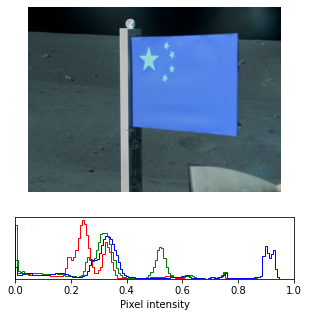

Exporting resulting HDR image
DONE


In [106]:
fn = []
img = []
exp = []

for filename in p:
    f = open(filename, 'r')
    header = f.read()
    i = re.search('<exposure_time unit="ms">(.*?)</exposure_time>', header).group(1)
    exp.append(float(i))
    f.close()
    
for filename in glob.glob('*.png'):
    fn.append(filename)
    img.append(cv.imread(filename))
print('PNG image list loaded.')

exp = np.array(np.divide(exp, 1000), dtype=np.float32)

#print('Exposure list: {}'.format(fn))
print('Exposure times (s): {}'.format(exp))

print('Merging images...')
merge = cv.createMergeDebevec()
hdr = merge.process(img, times=exp.copy())
#hdr = merge.process(img)
#print(hdr)

tonemap1 = cv.createTonemapMantiuk(gamma=1.5, scale=1, saturation=1.5)
result = tonemap1.process(hdr.copy())
#result = hdr

print('Generating preview...')
plot_img_and_hist(result, 'C', 5, True)
plt.show()

print('Exporting resulting HDR image')
result_8bit = np.clip(result*255, 0, 255).astype('uint8')
cv.imwrite('HDR.jpg', result_8bit)
print('DONE')
